## Попередня розвідка даних (EDA)

В процесі EDA ми вважаємо основні статистики і малюємо графіки, щоб знайти тренди, аномалії, патерни і зв'язку всередині даних. Мета EDA - дізнатися, що можуть розповісти дані. Зазвичай аналіз йде зверху вниз - від загального огляду до дослідження окремих зон, які привертають увагу і можуть становити інтерес.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sklearn.preprocessing as prep
import warnings
import logging
import sklearn.covariance as cov
from scipy.stats import chi2
from itertools import product
import seaborn as sns
import random
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import phik
from phik import resources, report

# відключення логерів та попереджень
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
log = logging.getLogger()
log.setLevel(logging.CRITICAL)

pd.set_option('display.max_columns', None)

Завантаження, перевірка даних

In [2]:
cleaned_data = pd.read_pickle('cleaned_data_1.pkl')

In [3]:
cleaned_data.TARGET = cleaned_data.TARGET.astype('int8')

In [4]:
metric_df = cleaned_data.loc[:,(np.array(cleaned_data.dtypes == "float64")) | (np.array(cleaned_data.dtypes == "int64"))].copy()
non_metric_df = cleaned_data.loc[:,(np.array(cleaned_data.dtypes !="float64")) & (np.array(cleaned_data.dtypes != "int64"))].copy()
non_metric_df = non_metric_df[[col for col in non_metric_df.columns if col != 'TARGET']]

In [5]:
assert (len(cleaned_data.columns) == len(metric_df.columns) + len(non_metric_df.columns) + 1)

__Розподіл цільової (таргетної) змінної__

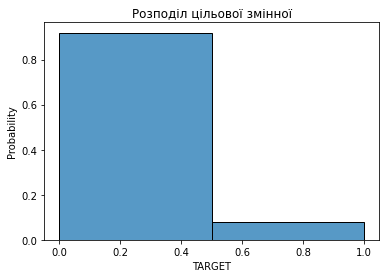

In [6]:
fig, ax = plt.subplots()
sns.histplot(cleaned_data.TARGET, ax=ax, stat='probability', bins=2)
ax.set_title('Розподіл цільової змінної')
plt.show()

__Кореляція метричних ознак__

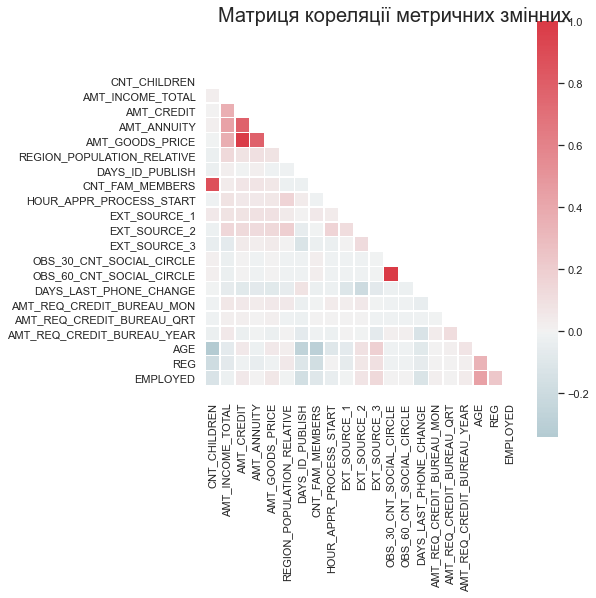

In [7]:
# correlation matrix plot with seaborn
def plot_corr_matrix(metric_df, abs_apply=False, values=False, fig_size = (7, 7)):    
    sns.set(style="white")

    # correlation matrix with pandas
    corr = metric_df.corr()
    if abs_apply == True:
        corr = corr.apply(np.abs)
    
    # mask generation for upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True

    # matplotlib figure
    fig, ax = plt.subplots(figsize=fig_size)

    # colormap generation
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
        
    # seaborn heatmap, scale correlation
    if values:
        mask_annot = np.absolute(corr.values)>=0.70
        annot_arr = np.where(mask_annot, corr.values.round(2), np.full(fig_size,""))
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")
    else:
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

    # show matplotlib figure
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Матриця кореляції метричних змінних", fontsize=20)
    plt.yticks(rotation=0)
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)

    plt.show()

plot_corr_matrix(metric_df)

Видалення мультиколінеарних змінних

In [8]:
cleaned_data.drop(columns=['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_CHILDREN', 'OBS_60_CNT_SOCIAL_CIRCLE'], inplace=True)
metric_df.drop(columns=['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_CHILDREN', 'OBS_60_CNT_SOCIAL_CIRCLE'], inplace=True)

__Кореляція усіх змінних з таргетом__

In [9]:
correlations = cleaned_data.corr()['TARGET'].sort_values().apply(np.abs)
corr_features = list(correlations.index)[:5]
correlations.head(5)

EXT_SOURCE_3    0.162504
EXT_SOURCE_2    0.161559
EMPLOYED        0.082726
AGE             0.079148
EXT_SOURCE_1    0.064340
Name: TARGET, dtype: float64

In [10]:
cleaned_data[corr_features].describe()

,EXT_SOURCE_3,EXT_SOURCE_2,EMPLOYED,AGE,EXT_SOURCE_1
count,285195.000000,2.851950e+05,285195.000000,285195.000000,285195.000000
mean,0.511349,5.139124e-01,7.308624,43.501418,0.217905
std,0.172607,1.901289e-01,6.004019,11.892621,0.284452
min,0.000527,8.173617e-08,-0.000000,21.000000,0.000000
25%,0.418854,3.928720e-01,2.594521,34.000000,0.000000
50%,0.520023,5.651232e-01,6.087671,43.000000,0.000000
75%,0.634706,6.621658e-01,10.739413,53.000000,0.453839
max,0.896010,8.549997e-01,49.073973,69.000000,0.962693


__Гістограми та розподіл ядерної щільності для найбільш корелюючих ознак__

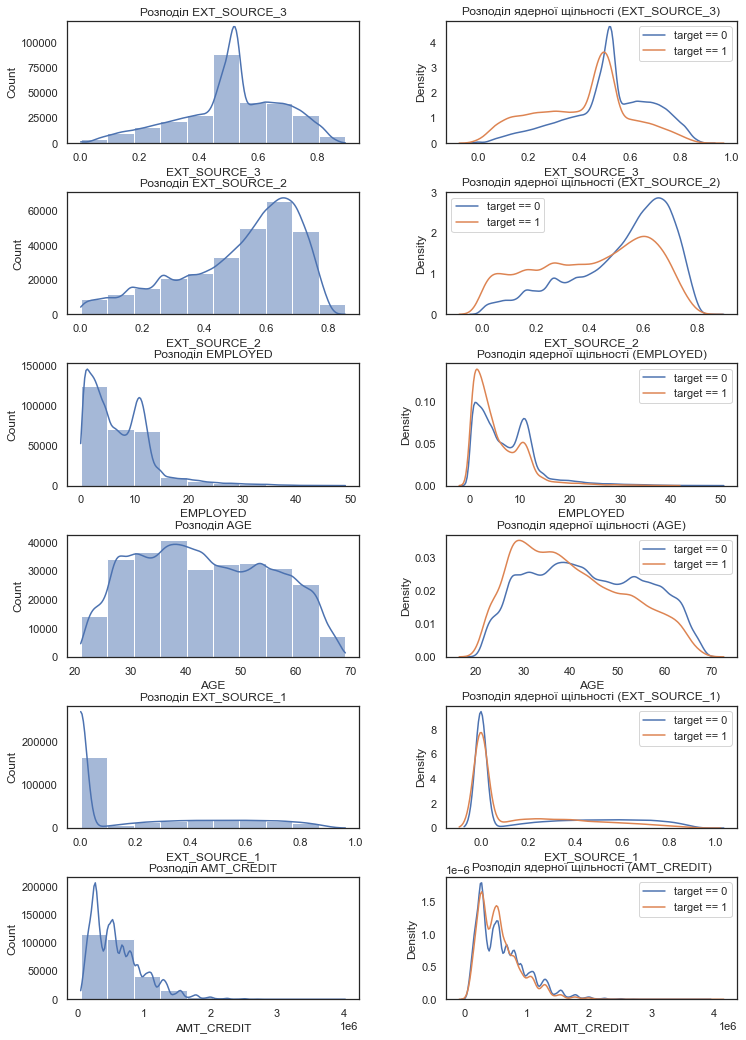

In [11]:
corr_features += ['AMT_CREDIT']
fig, ax = plt.subplots(6, 2, figsize=(12, 18))
for n in range(len(corr_features)):
    sns.histplot(cleaned_data[corr_features[n]], bins=10, kde=True, ax=ax[n, 0])
    ax[n, 0].set_title('Розподіл {}'.format(corr_features[n]))
    sns.kdeplot(data = cleaned_data.loc[cleaned_data['TARGET'] == 0], x = corr_features[n], label = 'target == 0', ax = ax[n, 1])
    sns.kdeplot(data = cleaned_data.loc[cleaned_data['TARGET'] == 1], x = corr_features[n], label = 'target == 1', ax = ax[n, 1])
    ax[n, 1].legend()
    ax[n, 1].set_title('Розподіл ядерної щільності ({})'.format(corr_features[n]))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

In [12]:
cleaned_data.to_pickle('cleaned_data_2.pkl')